### RNA Velocity with Salmon-Alevin/scVelo

#### As mentioned in the [Rmd overview](https://github.com/trichelab/single_cell_analyses/blob/master/rnavel_alevin_scvelo.Rmd) of this analysis pipeline, this workflow primarily follows this github [page](https://combine-lab.github.io/alevin-tutorial/2020/alevin-velocity/), it proceeds along 4 main steps:

   1. Installation of pre-requisite software components <br>
   2. Downloading and indexing the genome <br>
   3. Aligning your sequencing reads to intronic and exonic regions of the genome <br>
   4. Performing the RNA Velocity calculation <br>

#### Step 1. Installation of pre-requisite software components

- Install anaconda [here](https://docs.anaconda.com/anaconda/install/), or miniconda [here](https://docs.conda.io/en/latest/miniconda.html).
- Install R ≥ v 4.0 [here](https://repo.miserver.it.umich.edu/cran/).
- If you already have R < v 4.0, run `updateR()` within the R terminal to update to the latest version.

#### Step 2. Downloading and indexing the reference genome

**A. Download reference genome and the corresponding gtf file. In this example, we are using Gencode Grch38 primary assembly** 

`wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_34/GRCh38.primary_assembly.genome.fa.gz` <br>
`wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_34/gencode.v34.annotation.gtf.gz`

Now, it's time to open R (can be done locally or through HPC) and import (or install if you have not done so) packages required. The R script for indexing the reference and creating a linked transcriptome with tximeta is **[here](https://github.com/trichelab/single_cell_analyses/blob/master/Rscripts/step2_index_ref_genome.R)**.

**B. Preparing transcriptome indices using Salmon**

- **First of, install salmon using conda (if you have not done so)**

`conda config --add channels conda-forge`<br>
`conda config --add channels bioconda` <br> 
`conda create -n salmon salmon` <br> 
`conda activate salmon`

- **Indexing with salmon**

`grep ">" GRCh38.primary_assembly.genome.fa | cut -d ">" -f 2 | cut -d " " -f 1 > GRCh38.primary_assembly.genome.chrnames.txt`<br>
`salmon index \`<br>
`-t <(cat gencode.v34.annotation.expanded.fa GRCh38.primary_assembly.genome.fa) \`<br>
`-i gencode.v34.annotation.expanded.sidx --gencode -p 32 \`<br>
`-d GRCh38.primary_assembly.genome.chrnames.txt`

- **Now, it's time to create a linked transcriptome with tximeta (refer to the [Rscript](https://github.com/trichelab/single_cell_analyses/blob/master/Rscripts/step2_index_ref_genome.R)) **

#### Step 3. Align and quantify reads to intronic and exonic regions of the genome

**A. We will use MPAL (Mixed-Phenotype Acute Leukemia) scRNA-seq data set for this documentation from [Granja et al., 2019](https://www.nature.com/articles/s41587-019-0332-7.pdf?draft=collection). The following code downloads the bam file from SRA and uses the bamtofastq utility to convert it into a set of FASTQ files.**

`wget https://sra-pub-src-2.s3.amazonaws.com/SRR10343065/scRNA_BMMC_D1T1.bam.1` <br>
`mv scRNA_BMMC_D1T1.bam.1 scRNA_BMMC_D1T1.bam`<br>
`bamtofastq --reads-per-fastq=500000000 scRNA_BMMC_D1T1.bam FASTQtmp`<br>

**B. Run alevin to quantify the exonic and intronic abundances based on the index generated above.**<br>

`salmon alevin -l ISR -i gencode.v34.annotation.expanded.sidx \`<br>
`-1 BMMC_D1T1_S1_L001_R1_001.fastq.gz \`<br>
`-2 BMMC_D1T1_S1_L001_R2_001.fastq.gz \`<br>
`-o alevin_out -p 36 --tgMap gencode.v34.annotation.expanded.tx2gene.tsv \`<br>
`--chromium --dumpFeatures --expectCells 1850`

**C. Import abundances into R with tximeta**

refer to the [Rscript](https://github.com/trichelab/single_cell_analyses/blob/master/Rscripts/step4_import_abundances.R)

#### Step 4. Perform RNA velocity calculation with scVelo

In [1]:
import sys

#install packages from terminal 
#e.g. 
#python -m pip install --user git+https://github.com/theislab/scvelo)
#add path, which point to where the modules are installed with 
#sys.path.append("path/to/module")

#print python path environment variable
print(sys.path) 

['', 'C:\\Users\\Pamela Himadewi\\Anaconda3\\python36.zip', 'C:\\Users\\Pamela Himadewi\\Anaconda3\\DLLs', 'C:\\Users\\Pamela Himadewi\\Anaconda3\\lib', 'C:\\Users\\Pamela Himadewi\\Anaconda3', 'C:\\Users\\Pamela Himadewi\\AppData\\Roaming\\Python\\Python36\\site-packages', 'C:\\Users\\Pamela Himadewi\\Anaconda3\\lib\\site-packages', 'C:\\Users\\Pamela Himadewi\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\Pamela Himadewi\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Pamela Himadewi\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Pamela Himadewi\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Pamela Himadewi\\.ipython']


In [2]:
import scvelo as scv
import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import leidenalg
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as pl
from matplotlib import rcParams
import louvain

In [3]:
from __main__ import *
import os

os.environ['R_HOME'] = 'C:\\Program Files\\R\\R-4.0.1'
os.environ['R_USER'] = 'C:\\Users\\Pamela Himadewi\\AppData\\Roaming\\Python\\Python36\\site-packages\\rpy2'

In [4]:
import rpy2
from rpy2.robjects import r
from rpy2.robjects.packages import importr
import anndata

In [5]:
import anndata2ri
anndata2ri.activate()

sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)
scv.logging.print_version()
scv.settings.set_figure_params('scvelo')

scanpy==1.4.6 anndata==0.7.2.dev82+g2e37bb6 umap==0.4.1 numpy==1.18.1 scipy==1.3.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.7.0
Running scvelo 0.1.26.dev189+gc441c72 (python 3.6.4) on 2020-06-10 14:04.


In [6]:
#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

In [9]:
base = importr('base', lib_loc="C:/Users/Pamela Himadewi/AppData/Roaming/Python/Python36/site-packages/rpy2/R/win-library/4.0")
print(base._libPaths())

['C:/Users/Pamela Himadewi/AppData/Roaming/Python/Python36/site-packages/rpy2/R/win-library/4.0'
 'C:/Program Files/R/R-4.0.1/library']


In [11]:
%%R
BMMC_sce <- readRDS(file="C:\\Users\\Pamela Himadewi\\Documents\\TricheLab_gitrepo\\single_cell_analyses\\Rscripts\\BMMC_txi_alevin_abundance.rds")
CD34_sce <- readRDS(file="C:\\Users\\Pamela Himadewi\\Documents\\TricheLab_gitrepo\\single_cell_analyses\\Rscripts\\CD34_txi_alevin_abundance.rds")
MPAL1_sce <- readRDS(file="C:\\Users\\Pamela Himadewi\\Documents\\TricheLab_gitrepo\\single_cell_analyses\\Rscripts\\MPAL1_txi_alevin_abundance.rds")
MPAL2_sce <- readRDS(file="C:\\Users\\Pamela Himadewi\\Documents\\TricheLab_gitrepo\\single_cell_analyses\\Rscripts\\MPAL2_txi_alevin_abundance.rds")
MPAL3_sce <- readRDS(file="C:\\Users\\Pamela Himadewi\\Documents\\TricheLab_gitrepo\\single_cell_analyses\\Rscripts\\MPAL3_txi_alevin_abundance.rds")
MPAL4_sce <- readRDS(file="C:\\Users\\Pamela Himadewi\\Documents\\TricheLab_gitrepo\\single_cell_analyses\\Rscripts\\MPAL4_txi_alevin_abundance.rds")
MPAL5_sce <- readRDS(file="C:\\Users\\Pamela Himadewi\\Documents\\TricheLab_gitrepo\\single_cell_analyses\\Rscripts\\MPAL5_txi_alevin_abundance.rds")
MPAL5R_sce <- readRDS(file="C:\\Users\\Pamela Himadewi\\Documents\\TricheLab_gitrepo\\single_cell_analyses\\Rscripts\\MPAL5R_txi_alevin_abundance.rds")

In [12]:
BMMC_adata = r('as(BMMC_sce, "SingleCellExperiment")')
CD34_adata = r('as(CD34_sce, "SingleCellExperiment")')
MPAL1_adata = r('as(MPAL1_sce, "SingleCellExperiment")')
MPAL2_adata = r('as(MPAL2_sce, "SingleCellExperiment")')
MPAL3_adata = r('as(MPAL3_sce, "SingleCellExperiment")')
MPAL4_adata = r('as(MPAL4_sce, "SingleCellExperiment")')
MPAL5_adata = r('as(MPAL5_sce, "SingleCellExperiment")')
MPAL5R_adata = r('as(MPAL5R_sce, "SingleCellExperiment")')

In [13]:
BMMC_adata

AnnData object with n_obs × n_vars = 7490 × 60289
    obs: 'sizeFactor'
    uns: 'tximetaInfo', 'quantInfo', 'countsFromAbundance', 'level', 'txomeInfo', 'txdbInfo'
    obsm: 'X_pca', 'X_tsne'
    layers: 'spliced', 'unspliced', 'logcounts'

In [14]:
CD34_adata

AnnData object with n_obs × n_vars = 4488 × 60289
    obs: 'sizeFactor'
    uns: 'tximetaInfo', 'quantInfo', 'countsFromAbundance', 'level', 'txomeInfo', 'txdbInfo'
    obsm: 'X_pca', 'X_tsne'
    layers: 'spliced', 'unspliced', 'logcounts'

In [15]:
#show proportions of spliced/unspliced abundances
scv.utils.show_proportions(BMMC_adata)

Abundance of ['spliced', 'unspliced']: [0.66 0.34]


In [16]:
#combine adata for the normal control
normal_adata = BMMC_adata.concatenate(CD34_adata, batch_categories=['BMMC', 'CD34'])

In [17]:
normal_adata

AnnData object with n_obs × n_vars = 11978 × 60289
    obs: 'sizeFactor', 'batch'
    obsm: 'X_pca', 'X_tsne'
    layers: 'spliced', 'unspliced', 'logcounts'

#### Integrating scanpy to do dimensionality reduction and UMAP clustering

In [18]:
sce_objects = [normal_adata, MPAL1_adata, MPAL2_adata, MPAL3_adata, MPAL4_adata, MPAL5_adata, MPAL5R_adata]

In [19]:
#using scanpy for dimensionality reduction
for adata in sce_objects:
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:34)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'dist

In [21]:
for adata in sce_objects:
    sc.tl.leiden(adata)

running Leiden clustering
    finished: found 32 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


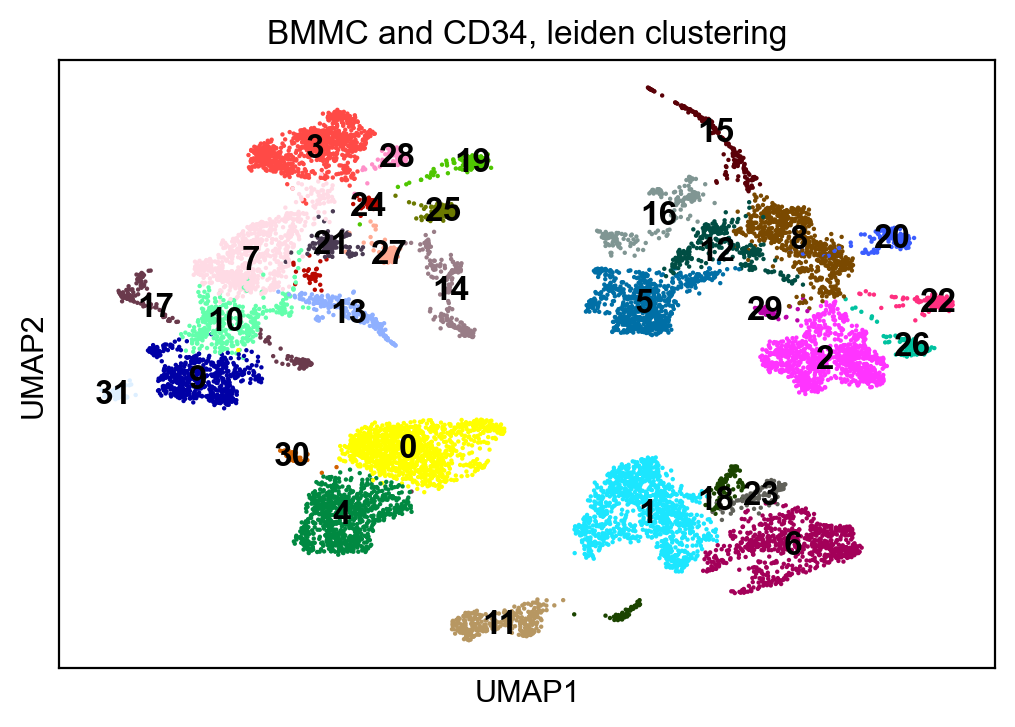

In [34]:
sc.pl.umap(normal_adata, color='leiden', legend_loc='on data', title='BMMC and CD34, leiden clustering')

In [ ]:
#marker_genes=["GATA1"] #HSC

In [ ]:
#sc.pl.dotplot(BMMC_adata, marker_genes, groupby='leiden')
#sc.pl.violin(BMMC_adata, ['Cd19'], groupby='leiden')

In [23]:
#filtering out genes that are shared in less than min_shared_counts 
for adata in sce_objects:
    scv.pp.filter_genes(adata, min_shared_counts = 30)
    scv.pp.normalize_per_cell(adata, enforce = True)

Filtered out 46544 genes that are detected in less than 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Filtered out 54858 genes that are detected in less than 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Filtered out 52447 genes that are detected in less than 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Filtered out 54247 genes that are detected in less than 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Filtered out 51626 genes that are detected in less than 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Filtered out 53481 genes that are detected in less than 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Filtered out 53282 genes that are detected in less than 30 counts (shared).
Normalized count data: X, spliced, unspliced.


In [24]:
for adata in sce_objects:
    scv.pp.filter_genes_dispersion(adata, n_top_genes = 2000)
    scv.pp.log1p(adata)
    scv.pp.moments(adata, n_pcs = 30, n_neighbors = 30)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:06)
computing neighbors
    finished (0:00:23) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:08) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency

In [25]:
for adata in sce_objects:
    scv.tl.recover_dynamics(adata)

recovering dynamics
    finished (3:05:32) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
recovering dynamics
    finished (0:02:13) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
recovering dynamics
    finished (0:05:51) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
recovering dynamics
    finished (0:01:03) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
recovering dynamics
    finished (0:02:17) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
recovering dynamics
    finished (0:03:58) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
recovering dynamics
    finished (0:01:35) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [26]:
for adata in sce_objects:
    scv.tl.velocity(adata, mode = 'dynamical')

computing velocities
    finished (0:00:33) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [28]:
for adata in sce_objects:
    scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:27) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph
    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph
    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity graph
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


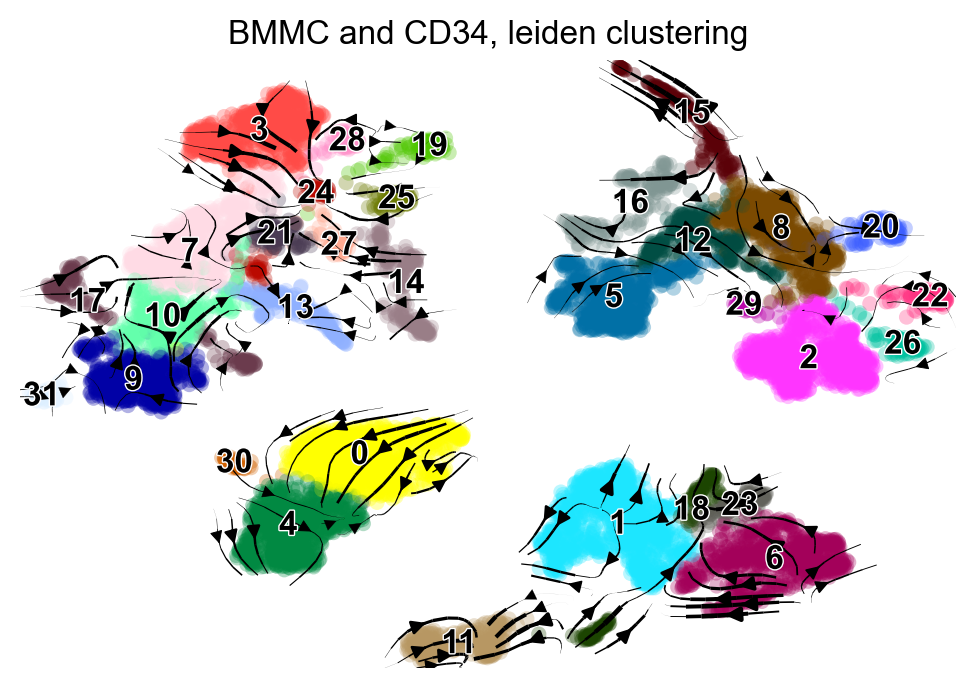

In [35]:
scv.pl.velocity_embedding_stream(normal_adata, basis='X_umap', color='leiden', title='BMMC and CD34, leiden clustering')

#### Step 5. Integrating some other interesting bits

- **CellRank**, a toolkit to uncover cellular development based on scRNA-seq data with RNA velocity annotation https://cellrank.readthedocs.io/en/latest/

In [36]:
#using cellrank to infer root and final states of development as well as lineage probabilities
import cellrank as cr 

In [37]:
scv.tl.velocity_graph(normal_adata, mode_neighbors='connectivities', n_recurse_neighbors=0)

computing velocity graph
    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Computing `final_cells`
Computing transition matrix based on velocity correlations
    Finish (0:00:00)
Computing eigendecomposition of transition matrix
Computing approximate recurrent classes
Adding `adata.uns['final_cells_colors']`
       `adata.obs['final_cells_probs']`
       `adata.obs['final_cells']`
       `.approx_recurrent_classes_probabilities`
       `.approx_recurrent_classes`
    Finish (0:00:01)


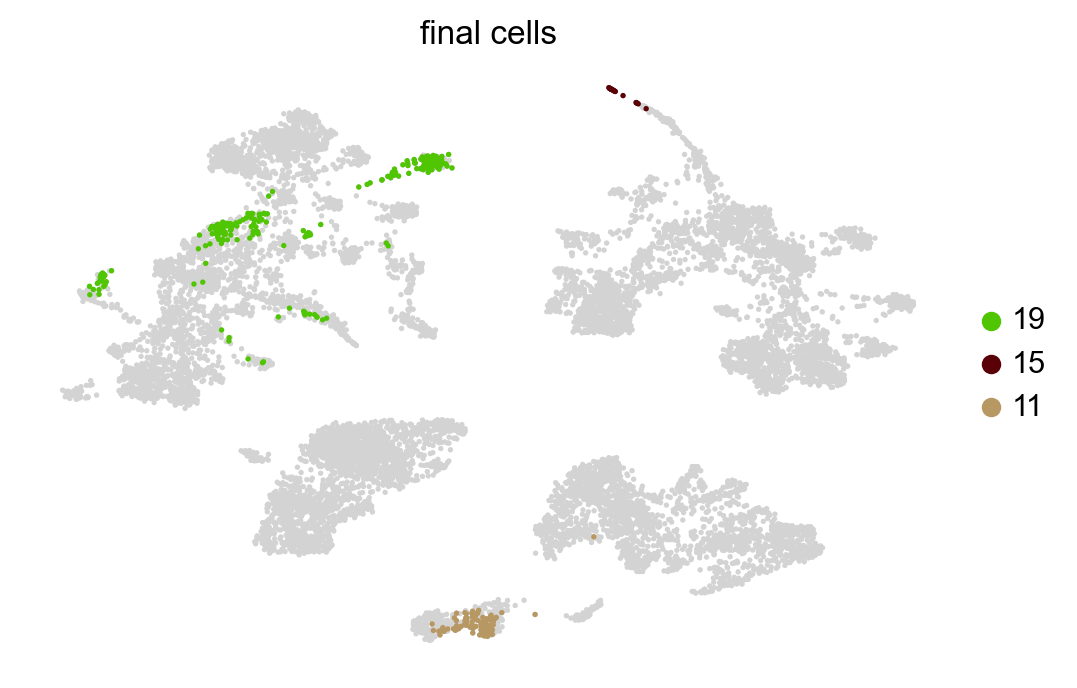

In [38]:
#find the final states of development
cr.tl.find_final(normal_adata, cluster_key='leiden')
scv.pl.scatter(normal_adata, color='final_cells', legend_loc='right margin')

Computing `root_cells`
Computing transition matrix based on velocity correlations
    Finish (0:00:00)
Computing eigendecomposition of transition matrix
Computing approximate recurrent classes
Adding `adata.uns['root_cells_colors']`
       `adata.obs['root_cells_probs']`
       `adata.obs['root_cells']`
       `.approx_recurrent_classes_probabilities`
       `.approx_recurrent_classes`
    Finish (0:00:00)


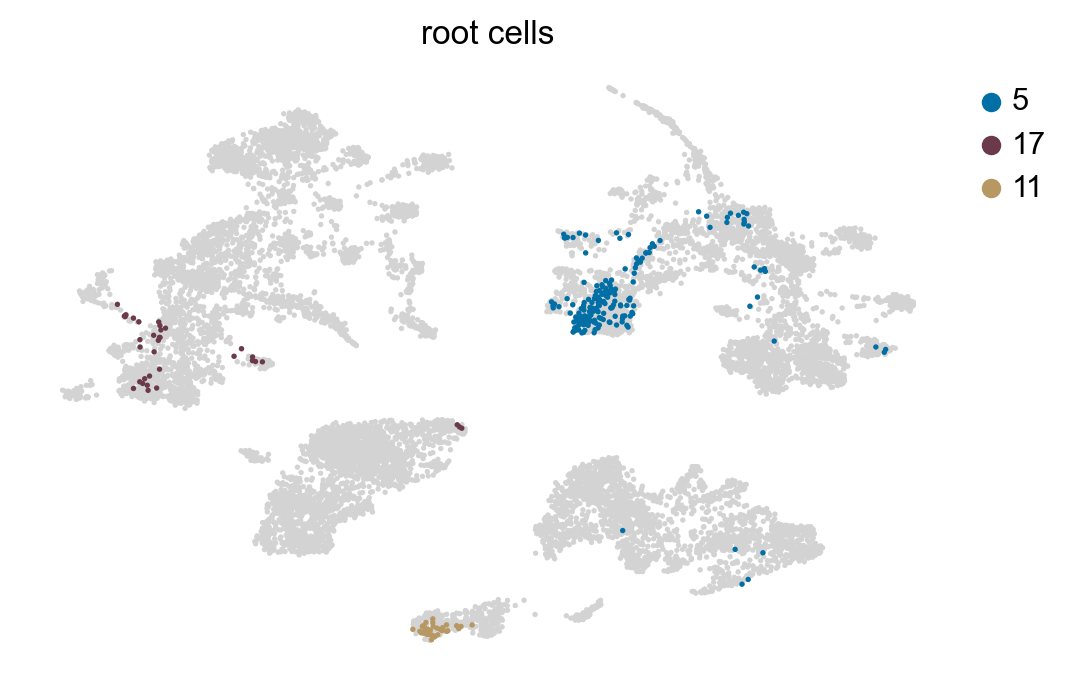

In [39]:
#find the final states of development
cr.tl.find_root(normal_adata, cluster_key='leiden') 
scv.pl.scatter(normal_adata, color='root_cells')